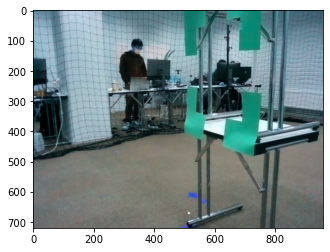

In [73]:
import cv2 
import numpy as np
import math
import matplotlib.pyplot as plt
img = cv2.imread('picture11.png') # Importing Sample Test Image
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)  # Showing The Sample Test Image

width = int(img.shape[1] * 50 / 100)
height = int(img.shape[0] * 50 / 100)
dim = (width, height)

# Resize the gate

<class 'numpy.ndarray'>
(360, 480, 3)


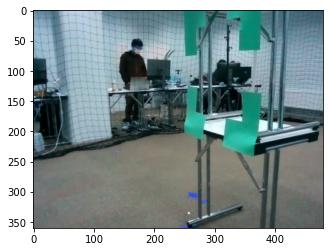

In [74]:
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print(type(img))    # Print the img variable data type
print(np.shape(img))  # Print the img variable dimension

plt.imshow(img)


# Turn it to hsv, filter the green and threshold it 

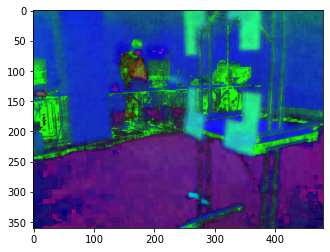

In [75]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(img_hsv)

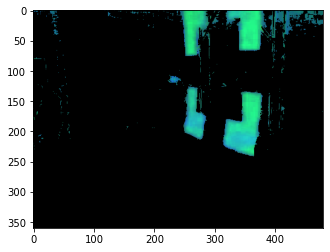

In [76]:
lower_range = np.array([20, 100, 90])  # Set the Lower range value of color in BGR
upper_range = np.array([70, 255,255])   # Set the Upper range value of color in BGR
mask = cv2.inRange(img_hsv,lower_range,upper_range) # Create a mask with range
result = cv2.bitwise_and(img_hsv,img_hsv,mask = mask)  # Performing bitwise and operation with mask in img variable
plt.imshow(result)
#plt.imshow(mask, cmap="gray")

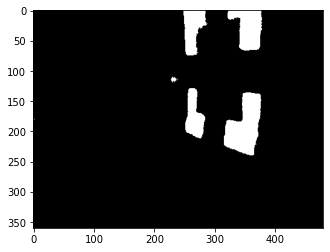

In [77]:
gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
#gray = np.float32(gray)
#plt.imshow(gray)
(thresh, black) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
#plt.imshow(black)
plt.imshow(black, cmap = "gray") #for black and white image
#print(np.shape(black))

# For some cases the dilation is necessary, in others it can obstruct the main object and detect less corners. Have to think about a case responsive filtering. Idea: depending on the density of green pixels over an area we can use a harder filtering or a softer filtering

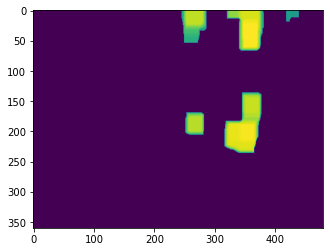

In [82]:
blurred = cv2.medianBlur(gray, ksize= 7)
       
#laplacian = cv2.Laplacian(blurred,cv2.CV_32F, ksize =1)
        #self.imshow_bgr(laplacian)
        
        #thresh = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)[1]
        #laplacian = cv2.Laplacian(thresh,cv2.CV_32F)
        
        
#        "creating long kernels type [1,1,1,1...] vert and hor"
#        "kerneldim = 19 seems a good startingpoint"
kerneldim = 23
kernelH    =  (1/kerneldim)*np.ones((1,kerneldim))
kernelV    =  (1/kerneldim)*np.ones((kerneldim, 1))
        
        
dilateV = blurred
#        "how many times to apply, more than 2 does veeeeeeery little"
for i in range(1):
    erodeH=cv2.erode(dilateV, kernelH, iterations=1)
    dilateH=cv2.dilate(erodeH, kernelH, iterations=1)
            
    erodeV=cv2.erode(dilateH, kernelV, iterations=1)
    dilateV=cv2.dilate(erodeV, kernelV, iterations=1)
            #print(i)
    plt.imshow(dilateV)

# Detect contours and draw bounding boxes 

3925.0
1603.0
2475.0
1816.0


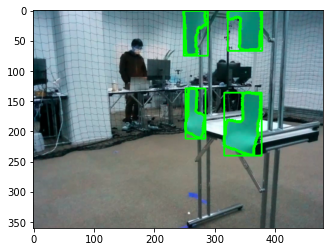

In [89]:
arr = np.uint8(black)
##### or we if we want the dilated version
#arr = np.uint8(dilateV)
contours, hierarchy = cv2.findContours(arr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

dummy = img.copy()  

for c in contours:
    #print(cv2.contourArea(c))
    if cv2.contourArea(c) > 100:
        # Draw all contours
        # -1 signifies drawing all contours
        print(cv2.contourArea(c))
        cv2.drawContours(dummy, c, -1, (0, 255, 0), 3)
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(dummy,(x,y),(x+w,y+h),(0,255,0),2)
        #cv2.putText(dummy2,'Gate detected {}'.format(i),(x+w+10,y+h),0,0.9,(0,255,0))

plt.imshow(dummy)
#cv2.imshow('Contours', dummy2)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# Find L-shaped corners of the gate

3925.0
1603.0
2475.0
1816.0
We detected 4 corners


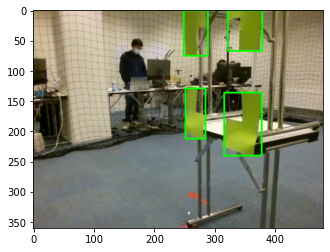

In [87]:
arr = np.uint8(black)
##### or we if we want the dilated version
#arr = np.uint8(dilateV)
contours, _ = cv2.findContours(arr, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

dummy1 = img.copy()
i=0
lshape = []

for c in contours:
    rect = cv2.boundingRect(c)
    contarea = cv2.contourArea(c)
    # Iterate through all the contours
  
    if contarea > 100:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.03 * peri, True)
        #print(len(approx))        
        if len(approx) >= 5 and len(approx) <=7: # we only box the L shaped corners
            i=i+1
            lshape.append(c)
            x,y,w,h = rect
            cv2.rectangle(dummy1,(x,y),(x+w,y+h),(0,255,0),2)
            #cv2.putText(dummy1,'Shape {}'.format(i),(x+w+10,y+h),0,0.7,(0,255,0))
            print(cv2.contourArea(c))

print("We detected {} corners".format(i))
plt.imshow(cv2.cvtColor(dummy1, cv2.COLOR_BGR2RGB))

# Combine L-shaped corners into a bounding box

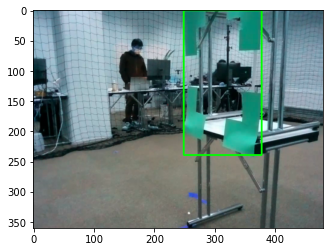

In [90]:
maxy = 0
miny = img.shape[0]
maxx = 0
minx = img.shape[1]

# HERE WE GET THE LIMITS OF THE BOUNDING BOX AROUND THE CORNERS BY FINDING THE OVERALL BOUNDING LIMITS
# OF ALL CONTOURS IN L-SHAPE
# WE USE THE POINTS IN THE CONTOURS 
for c in lshape:
    for i in c: 
        
        if i[0][1] < miny:   
            miny = i[0][1]
        if i[0][1] > maxy:   
            maxy = i[0][1]    
        if i[0][0] < minx:
            minx = i[0][0]
        if i[0][0] > maxx:
            maxx = i[0][0]
        
#print(miny)
#print(maxy)
#print(minx)
#print(maxx)

left_d_corner = (minx,maxy)
right_d_corner = (maxx, maxy)
left_u_corner = (minx,miny)
right_u_corner = (maxx,miny)
drawline = img.copy()
drawline = cv2.line(drawline, left_d_corner, right_d_corner, (0, 255, 0 ), 3)
drawline = cv2.line(drawline, left_u_corner, right_u_corner, (0, 255, 0 ), 3)
drawline = cv2.line(drawline, left_d_corner, left_u_corner, (0, 255, 0 ), 3)
drawline = cv2.line(drawline, right_d_corner, right_u_corner, (0, 255, 0 ), 3)

#plt.imshow(drawline)


#### OR WE CAN USE THE CV2.RECTANGLE FUNCTION

x = minx
y = miny
w = maxx - minx
h = maxy - miny

drawline2 = img.copy()
cv2.rectangle(drawline2,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(drawline2)

######### WE CAN IMPROVE THIS ALGORITHM AND GENERALIZE TO ONLY 2 CORNERS BY TAKING THE UPPER RIGHT AND LOWEST LEFT CORNERS AND DRAWING 
######### PARALLEL LINES WITH THE AXES/ THE UPPER LEFT AND LOWEST RIGHT CORNER

# Find the biggest contour and draw a bounding box around it

8
3925.0
(316, 136, 62, 104)


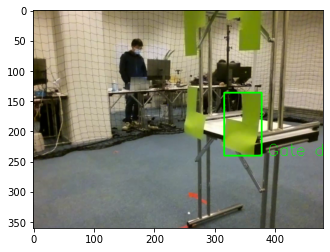

In [81]:
arr = np.uint8(black)
##### or we if we want the dilated version
#arr = np.uint8(dilateV)
contours, _ = cv2.findContours(arr, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
rects = []
for c in contours:
    rect = cv2.boundingRect(c)
    contarea = cv2.contourArea(c)
    rects.append([rect, contarea])

maximcontarea = 0.0
for i in rects:
    if i[1] > maximcontarea:
        maximcontarea = i[1]
        k = i[0]
print(maximcontarea)
print(k)
    
dummy2 = img.copy()

x,y,w,h = k
cv2.rectangle(dummy2,(x,y),(x+w,y+h),(0,255,0),2)
cv2.putText(dummy2,'Gate detected',(x+w+10,y+h),0,0.9,(0,255,0))
plt.imshow(cv2.cvtColor(dummy2, cv2.COLOR_BGR2RGB))

# Find the center of the biggest contour 

Gate is on the right side ---> Drone should move to the right


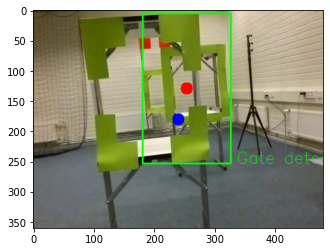

In [65]:
#calculate the center of the rectangle so we compare it with the center of the image

centerx = int((x+x+w)/2)
centery = int((y+y+h)/2)

centerximage = int(width/2)
centeryimage = int(height/2)

image = cv2.circle(dummy2, (centerx,centery), 10, (0, 0, 255), -1)
image = cv2.circle(dummy2, (centerximage,centeryimage), 10, (255, 0, 0), -1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
if centerx > centerximage:
    print("Gate is on the right side ---> Drone should move to the right")
elif centerx < centerximage:
    print("Gate is on the left side ---> Drone should move to the left")
else:
    print("Drone is alligned with the gate")

#Repeate for height adjustment